In [381]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")


***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - n \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum{i=1}^N y_i = 0 \\
& n \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{n} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{n} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{n} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x} - \hat{\beta}_1 x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [6]:
# Print description of Boston housing data set
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [7]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [8]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [9]:
print(boston.target.shape)

(506,)


In [10]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [11]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

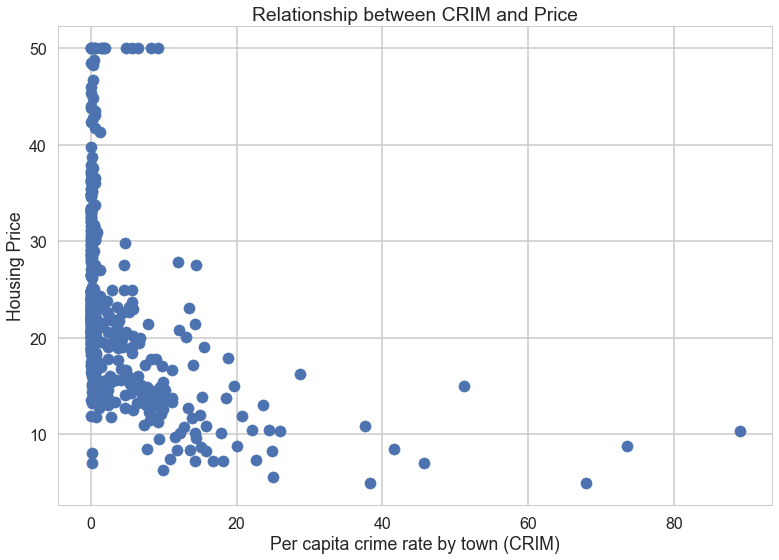

In [12]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

There appears to be a negative correlation between crime rate and housing prices. It makes sense that there would be a wide distribution of prices close to 0 crime rate. But as crime started to increase dramatically, it is expected to see housing price drops


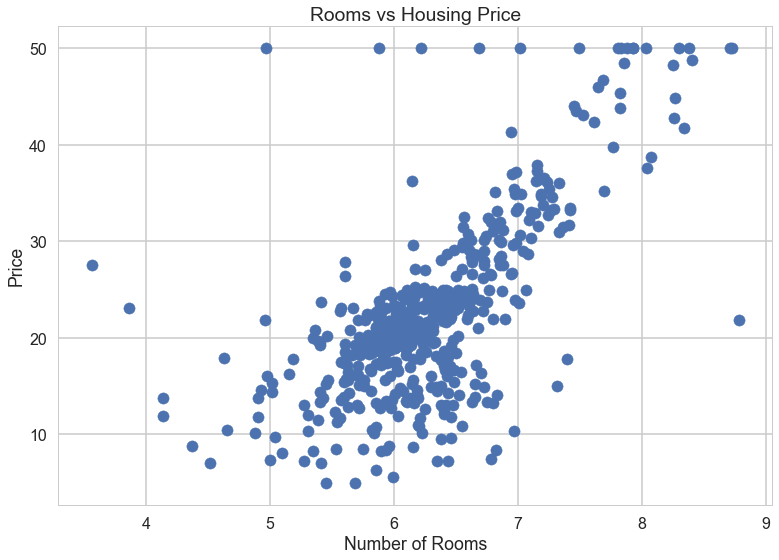

In [14]:
# your turn: scatter plot between *RM* and *PRICE*
plt.scatter(bos.RM, bos.PRICE)
plt.xlabel('Number of Rooms')
plt.ylabel('Price')
plt.title('Rooms vs Housing Price')
plt.show()

In [564]:
scipy.stats.pearsonr(bos.RM,bos.PRICE)[0]

0.69535994707153925

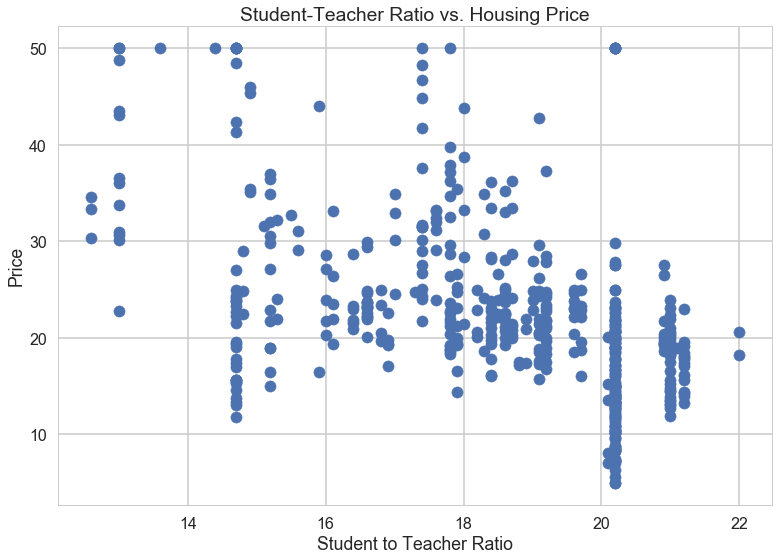

In [15]:
# your turn: scatter plot between *PTRATIO* and *PRICE*
plt.scatter(bos.PTRATIO,bos.PRICE)
plt.xlabel('Student to Teacher Ratio')
plt.ylabel('Price')
plt.title('Student-Teacher Ratio vs. Housing Price')
plt.show()

In [565]:
scipy.stats.pearsonr(bos.PTRATIO,bos.PRICE)[0]

-0.5077866855375619

There is obviously a strong positive correlation between the number of rooms and the price of a house. This is reflected in a pearson r score of 0.7. Conversely when analyzing the relationship of Student Teacher Ratio to Housing prices, qualitatively, there does appear to be a slight negative trend, but the spread of the prices leads one to believe that correlation is a weak one. This is slightly backed up from the pearson r score of -0.51

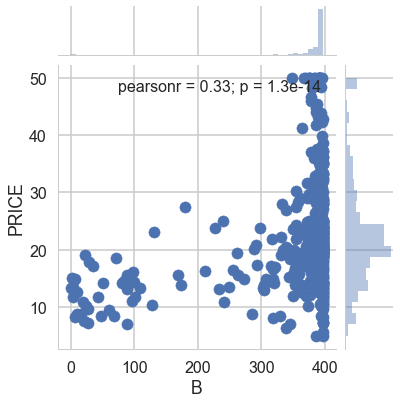

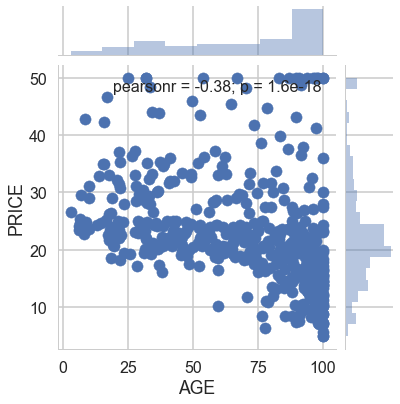

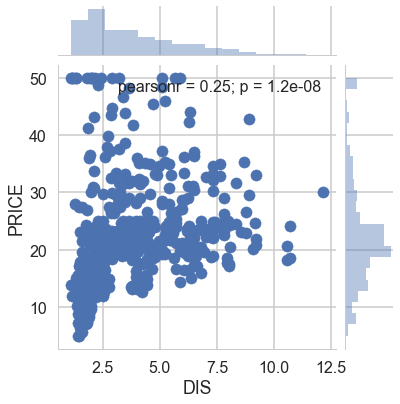

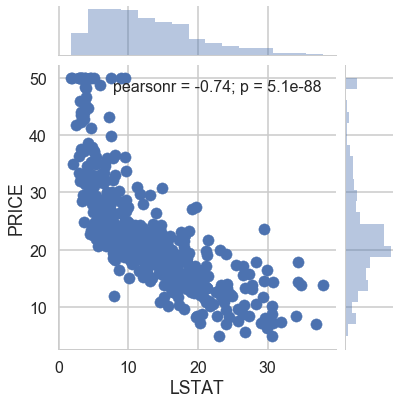

In [24]:
columns = ['B','AGE','DIS','LSTAT']
for column in columns:
    sns.jointplot(bos[column], bos.PRICE)
    plt.show()

In plotting the relationships above, surprisingly, both age and distance appear to have no affect on housing price. At least no strong correlation can be extrapolated. One would assume that a house's geographical location relative to certain areas of interest would increase/decrease price. The same could be assume about the Age of the house. However the distributions above clearly show no strong correlation.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

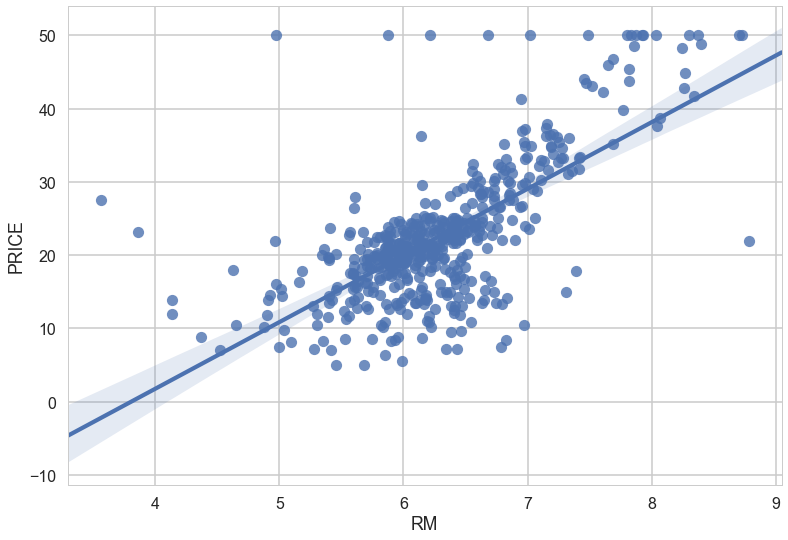

In [25]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)

### Histograms
***


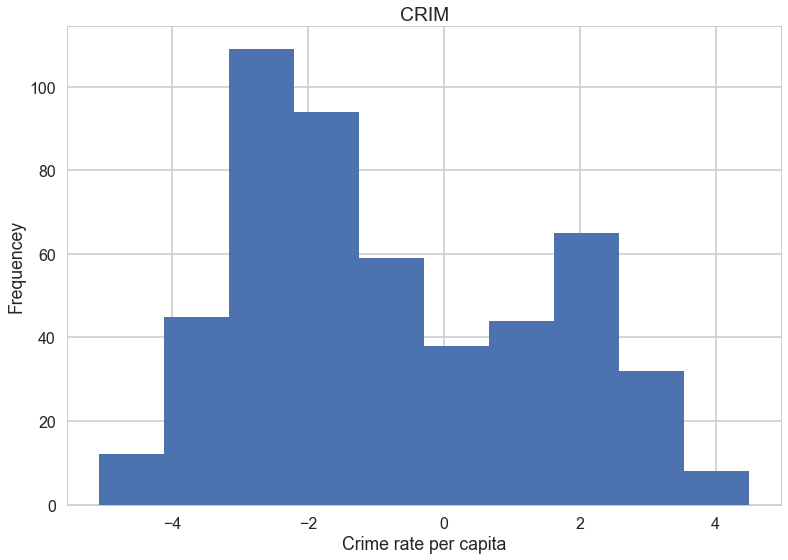

In [26]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot histograms for *RM* and *PTRATIO*, along with the two variables you picked in the previous section.</p>
</div>

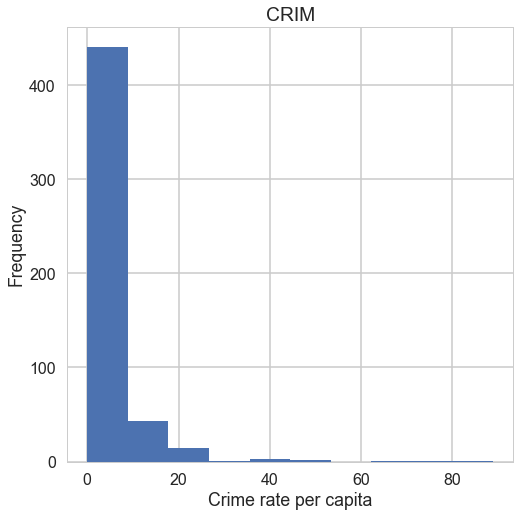

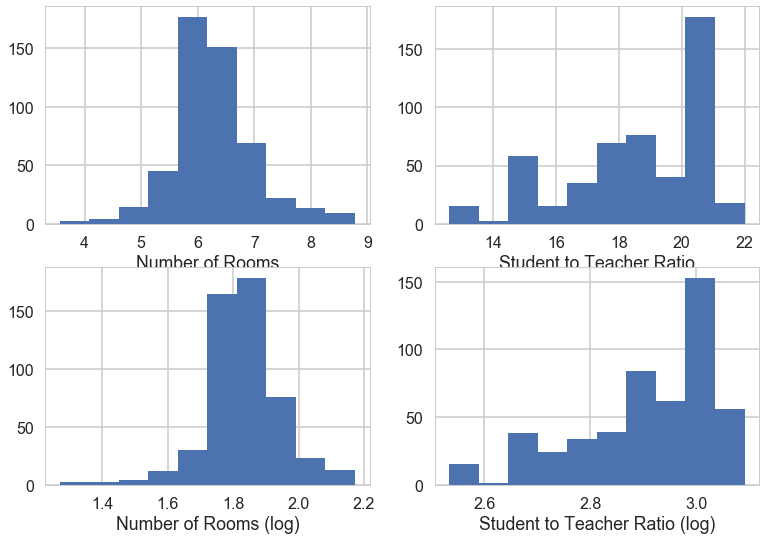

In [34]:
#your turn
fig = plt.figure(figsize=(8,8))
plt.hist(bos.CRIM)
plt.xlabel('Crime rate per capita')
plt.ylabel('Frequency')
plt.title('CRIM')
plt.show()

fig = plt.subplots(2,2)
ax1 = plt.subplot(2,2,1)
plt.hist(bos.RM)
ax1.set_xlabel('Number of Rooms')
ax2 = plt.subplot(2,2,2)
plt.hist(bos.PTRATIO)
ax2.set_xlabel('Student to Teacher Ratio')
ax3 = plt.subplot(2,2,3)
plt.hist(np.log(bos.RM))
ax3.set_xlabel('Number of Rooms (log)')
ax4 = plt.subplot(2,2,4)
plt.hist(np.log(bos.PTRATIO))
ax4.set_xlabel('Student to Teacher Ratio (log)')
plt.show()

### Analysis
When plotting the historgram of crime rate without a log scale, we can see just how extremely skewed it is and doesn't reveal much of a pattern or trend. After performing a logarithmic transformation, the histogram reveals a bimodal distribution. Conversely when performing the same transformation on both the number of rooms and the student to teacher ratio, there's no new trend or pattern that is revealed

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [35]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [194]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           2.49e-74
Time:                        17:44:54   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

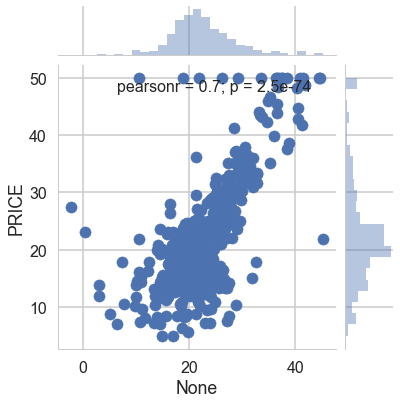

In [44]:
# your turn
sns.jointplot(m.fittedvalues,bos.PRICE)
plt.show()

There is a positive linear trend as one would expect to see after fitting their model. However there appears to be some weird pricing data around the \$500,000 range. These might be outliers in the Data

### Fitting Linear Regression using `sklearn`


In [45]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [ ]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [46]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://online.stat.psu.edu/~ajw13/stat501/SpecialTopics/Reg_thru_origin.pdf).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


### Excercise 1

In [60]:
# your turn
lm_no_intercept = LinearRegression(fit_intercept = False)
lm_no_intercept.fit(X, bos.PRICE)
print('Model Score with Intercept: {} \n Model Score without Intercept: {}'.format(lm.score(X,bos.PRICE), lm_no_intercept.score(X,bos.PRICE)))


Model Score with Intercept: 0.7406077428649428 
 Model Score without Intercept: 0.7136639021041447


### Exercise 2

Not only should the residuals be of a normal distribution, but when their values are plotted with respect to the X values, their spread (variance) should be relatively symmetricthroughout the distribution. For the residuals to have anything but a symmetric variance w.r.t X means that there is something wrong with our model. In the graph below, we can see that the residuals' variance is relatively symmetric w.r.t X. There does seem to be some violation of this symmetric rule around the observations of 370-380. These residuals are less than -20 and seem out of place

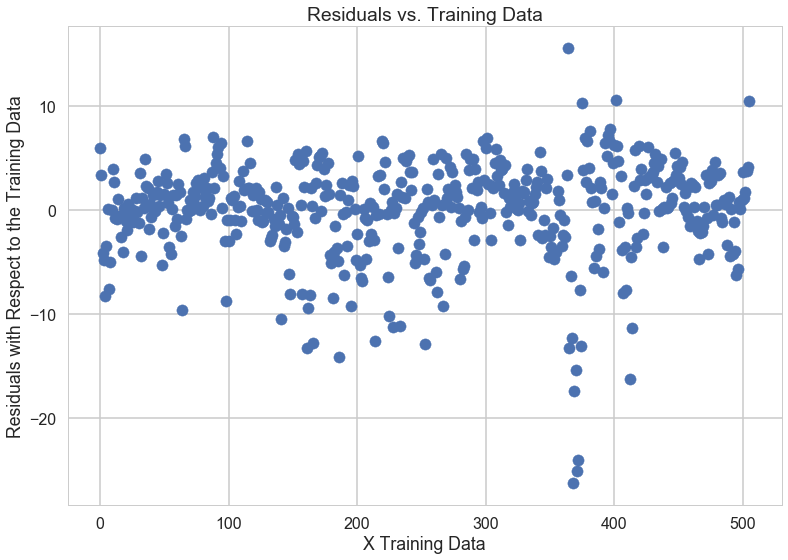

In [80]:
residuals = lm.predict(X) - bos.PRICE
plt.scatter(np.arange(len(X)),residuals)
plt.xlabel('X Training Data')
plt.ylabel('Residuals with Respect to the Training Data')
plt.title('Residuals vs. Training Data')
plt.show()

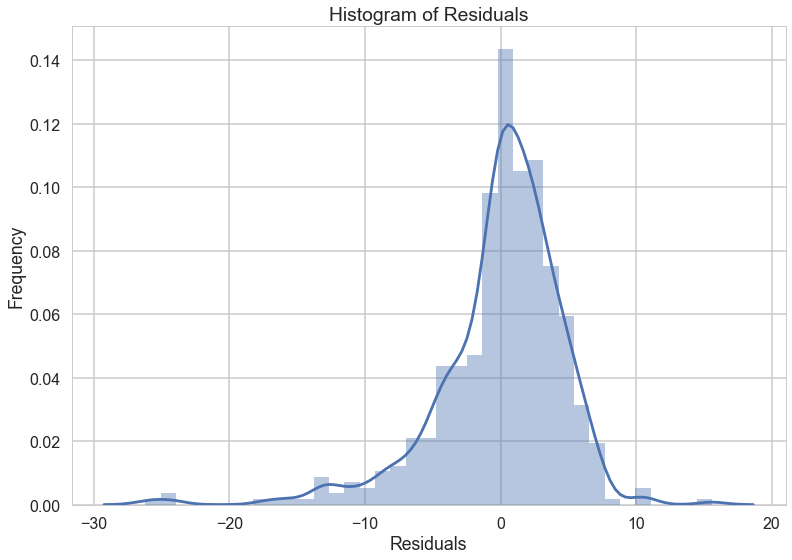

In [82]:
sns.distplot(residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Exercise 3

It is not required that **_Y_** be normally distributed. It is only required that the residuals be normally distributed centered around the mean of 0 and symmetric variance w.r.t X. The sum of all residuals must equal to 0 as well. By not meeting all this criteria, the linear model would not be as accurate and might suggest a higher order model (maybe quadratic) would be in order to best fit the training data. That or the removal of outliers

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [51]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.49110328036111


In [52]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [53]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [54]:
# first five predicted prices
lm.predict(X)[0:5]

array([ 30.00821269,  25.0298606 ,  30.5702317 ,  28.60814055,  27.94288232])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

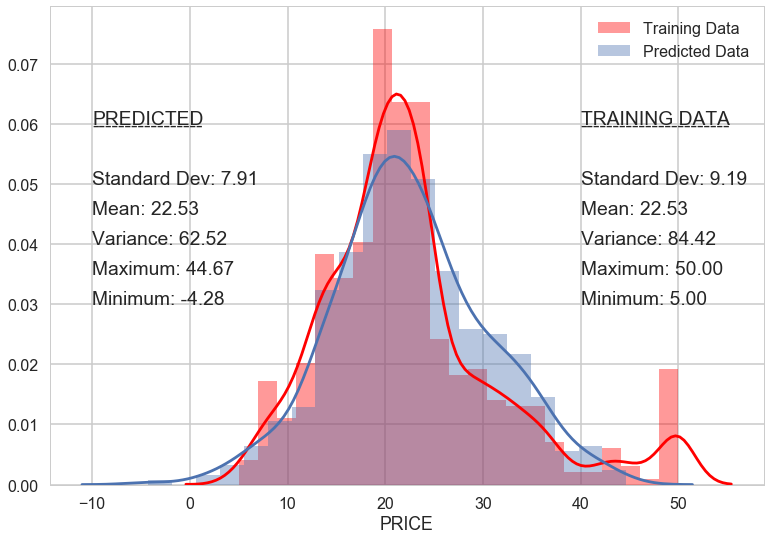

In [102]:
p_std = np.std(lm.predict(X))
p_mean = np.mean(lm.predict(X))
p_var = np.var(lm.predict(X))
p_maxx = np.max(lm.predict(X))
p_minn = np.min(lm.predict((X)))

std = np.std(bos.PRICE)
mean = np.mean(bos.PRICE)
var = np.var(bos.PRICE)
maxx = np.max(bos.PRICE)
minn = np.min(bos.PRICE)

fig = plt.figure()
sns.distplot(bos.PRICE, color ='r')
sns.distplot(lm.predict(X))


plt.text(-10,0.06, 'PREDICTED')
plt.text(-10,0.059, '-----------------')
plt.text(-10,0.05, 'Standard Dev: {:.2f}'.format(p_std))
plt.text(-10,0.045, 'Mean: {:.2f}'.format(p_mean))
plt.text(-10,0.04, 'Variance: {:.2f}'.format(p_var))
plt.text(-10,0.035, 'Maximum: {:.2f}'.format(p_maxx))
plt.text(-10,0.03, 'Minimum: {:.2f}'.format(p_minn))

plt.text(40,0.06, 'TRAINING DATA')
plt.text(40,0.059, '-----------------------')
plt.text(40,0.05, 'Standard Dev: {:.2f}'.format(std))
plt.text(40,0.045, 'Mean: {:.2f}'.format(mean))
plt.text(40,0.04, 'Variance: {:.2f}'.format(var))
plt.text(40,0.035, 'Maximum: {:.2f}'.format(maxx))
plt.text(40,0.03, 'Minimum: {:.2f}'.format(minn))

plt.legend(['Training Data','Predicted Data'])
plt.show()

When the predicted prices over overlayed with the training data prices, it is of note that the general shape of the distribution loosely matches the shape of the actual training data. However there is a significantly noticeable outlier in the predicted data. This outlier is the minimum value of -4.28. Obviously this makes no sense as a house can't have a negative price. This outlier can be attributed to the weak fit of the regression line to the original training data. The predicted data also appears to be somewhat of a normal distribution whereas the original training data is more right skewed. Given the outcome of this model, I would say that the model needs to be more fine tuned as opposed to just ignoring the negative outlier. This sentiment is compounded when you look at the predicted prices between the range of 0 and 5. The minimum house in the training data is of value 5.0 where the model has predicted housing prices between 0 and 5. In the same way a negative price makes no sense, a price of $0 is highly unlikely as well

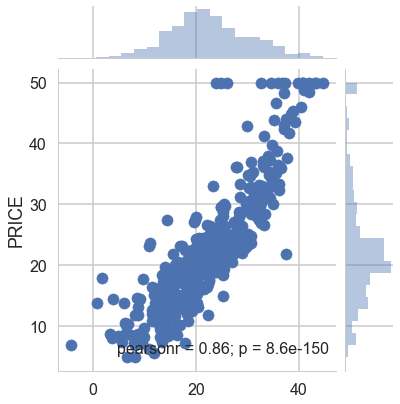

In [106]:
fig = plt.figure(figsize=(15,15))
sns.jointplot(lm.predict(X),bos.PRICE)
plt.show()

We can see a strong positive trend as indicated by the pearsonr coeffecient of 0.86. This is a good indication of a properly working model. However, take note at the training prices of value 50. Where the original price was 50, the model concluded these prices to be in the value range of 20 to 44. These values may be outliers as there are only a few in that price range. Given that all 13 features were used in training the model, it is safe to assume that maybe we should put more weight on particular features to account for these particular price ranges, or reduce the amount of variables used in the model. For instance it is reasonable to say that even though a house might have less rooms, it's price might be greater than normal due to its location in the city. We know this to be true in the real world as on average, buying an apartment downtown in a major city such as boston can cost as much if not more than a larger house further away from city center. Then again, we may just be relegated to believe these are just outliers. There's not enough information here to tell

Statsmodel has advantages in that it does provide a convenient one stop shop of all summary statistics. Using Scikit Learn, the user would have to know how to, and interact with the API to generate the same type of summary statistics. Also for user who are accustomed to using R, there is a smooth and familiar transition from R to python using statsmodel. However it does appear that the Scikit Learn library has resulted in a better fitted model

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [107]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11080.276284149875


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [133]:
print(np.sum(lm.predict(X) - np.mean(bos.PRICE)) ** 2)

7.36740044798e-23


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{ESS}{K}$$
$$MSR = \frac{RSS}{N-K-1}$$

**Remember: ** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Make a scatterplot of `PTRATIO` and housing price. Tell a story about the relationship between the variables.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

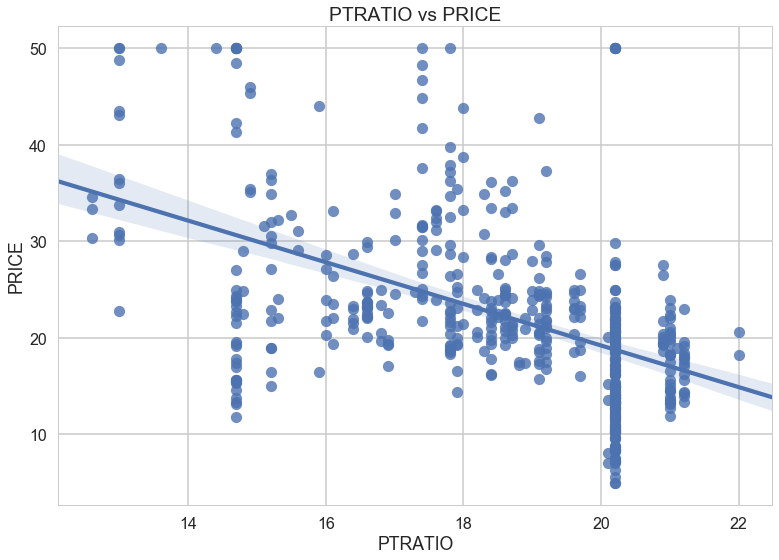

In [278]:
# your turn
ax = sns.regplot(bos.PTRATIO, bos.PRICE)
plt.title('PTRATIO vs PRICE')
plt.show()

In [277]:
#Calculate pearson r coeffecient
r = scipy.stats.pearsonr(bos.PTRATIO,bos.PRICE)[0]
print('Pearson r correlation: {}'.format(r))

Pearson r correlation: -0.5077866855375619


There appears to be a slight negative correlation between Student to Teacher ratio and the Housing Price data. This is highlighted by the pearson r coeffecient of -0.51. However the spread about the regression line is quite large, undoubtedly leading to a high cost value

### Fit a linear regression model using sklearn

In [283]:
#extract the PTRATIO as the independent variable X 
X = bos.PTRATIO.values
#reshape the values into a form sklearn accepts
X = X.reshape((X.shape[0],1))
#extract the price values as the dependent variable y
y = bos.PRICE
#instantiate a linear regression model
lm_ptratio = LinearRegression()

In [284]:
#fit the model to the independent and dependent variables
lm_ptratio.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [285]:
print('Coeffecient: {:.2f}'.format(lm_ptratio.coef_[0]))
print('Intercept: {:.2f}'.format(lm_ptratio.intercept_))

Coeffecient: -2.16
Intercept: 62.34


With a coeffecient of -2.16, this tells us that with every change of 1 in the PTRATIO, we can expect to see a drop in price by about 2.16 (\$21,600). An interpretation of the intercept is that with a student to teacher ratio of 0, we can expect to see a housing price point of \$623,400. Obviously this is non-sensical, as there is no area with a student teacher ratio of 0, but if we were so inclined to extrapolate such a value.

# Calculate $R^2$ - _(The hard way)_

### 1). Calculate the difference between the predicted values from the mean of the true values. Sum up the differences, and square the result (ESS)

In [286]:
#calculate the mean
y_hat = np.mean(y)
#calculate the predicted prices
y_predicted = lm_ptratio.predict(X)
#calculate the difference between the predicted and the mean of actual prices
difference = y_predicted - y_hat
#Square this result
difference_squared = difference ** 2
#sum this result
ESS = np.sum(difference_squared)
print(ESS)

11014.2822081


### 2). Calculate the difference between the true values and the predicted values. Sum up the differences, and square the result (RSS)

In [287]:
#calculate the difference between the actual values and the predicted
difference = y - y_predicted
#square this result
difference_squared = difference ** 2
#sum this result
RSS = np.sum(difference_squared)
print(RSS)

31702.013206967258


### 3.) Calculate TSS by adding RSS and ESS

In [288]:
#Add RSS and ESS
TSS = RSS + ESS
print(TSS)

42716.295415


### 4.) Calculate $R^2$ =  ESS / TSS

In [289]:
#calculate r squared
r_squared = ESS / TSS
print(r_squared)

0.257847318009


# Calculate F-statistic - _(The Hard Way)_

In [290]:
#number of variables in the model
k = X.shape[1]
#number of observations
n = X.shape[0]
#calculate mean squared error
mse = ESS / k
#Calculate the means square error of the residuals
msr = RSS / (n-k-1)
#Calculate F-score
F = mse/msr
df1 = n-k
df2 = k-1
print('F-Statistic: {}\n Degrees of Freedom 1: {}\n Degrees of Freedom 2: {}'.format(F,df1,df2))

F-Statistic: 175.1055428756957
 Degrees of Freedom 1: 505
 Degrees of Freedom 2: 0


# Calculate F-statistic - _(The Easy Way)_

In [292]:
import scipy
f = sklearn.feature_selection.f_regression(X, y, center=True)
print('F-statistic: {}'.format(f[0][0]))

F-statistic: 175.10554287569468


In [293]:
m = ols('PRICE ~ PTRATIO',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           1.61e-34
Time:                        20:18:44   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.0

## Analysis
---------------------------
If we go back up and look at the plot of PTRATIO vs PRICE, we can see that there was a negative trend, but the spread of the price about the line of best fit was very extreme. We can see this quantitatively in the $R^2$ value of 0.25. This means that 25% of the variance in price can be explained by the model. The model being "try to explain housing prices with only student to teacher ratio". A loose interpretation of this could be that, 25% of the distribution of housing prices in Boston can be attributed to the student teacher ratio in the area of the house. 

Analysis of the calculated F-statistic is explained with regards to the null and alternative hypothesis
> $H_0$: There is no difference between our model of coeffecients and a model of intercept only ($\beta_i$ for all i's = 0)

> $H_A$: The fit of the intercept-only model is significantly reduced compared to our model of coeffecients.

Because the probablity of our F-value is practically 0, this means that the chances of getting the level of variance we did had all the coeffecients been 0 (intercept only model) is 0. From this we can reject the null hypothesis and conclude that the coefficients we included in our model improved the model’s fit.

For the case of this single coeffecient model, the t-value of abs(-13.233) is the square root of the F-statistic (175.1)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

## Model with sklearn

In [294]:
# your turn
X = bos.loc[:,['CRIM','RM','PTRATIO']]
y = bos.PRICE
lm = LinearRegression()
lm.fit(X,y)
y_predict = lm.predict(X)
r_squared = sklearn.metrics.r2_score(y, y_predict, sample_weight=None, multioutput='uniform_average')
F = sklearn.feature_selection.f_regression(X, y, center=True)
print('Coeffecients: {}\nIntercept: {}'.format(lm.coef_,lm.intercept_))
print('R-squared score: {}'.format(r_squared))
print('F-statistic CRIM: {}          Prob: {}'.format(F[0][0], F[1][0]))
print('F-statistic RM: {}            Prob: {}'.format(F[0][1], F[1][1]))
print('F-statistic PTRATIO: {}       Prob: {}'.format(F[0][2], F[1][2]))

Coeffecients: [-0.20210971  7.3815667  -1.0741868 ]
Intercept: -3.3066171324065294
R-squared score: 0.5934141551136979
F-statistic CRIM: 88.15124178090035          Prob: 2.0835501108141935e-19
F-statistic RM: 471.846739876385            Prob: 2.4872288710091434e-74
F-statistic PTRATIO: 175.10554287569485       Prob: 1.6095094784733674e-34


In [243]:
lm_no_intercept = LinearRegression(fit_intercept = False)
lm_no_intercept.fit(X,y)
y_no_intercept_predict = lm_no_intercept.predict(X)
r_squared_no_intercept = sklearn.metrics.r2_score(y,y_no_intercept_predict)
F_no_intercept = sklearn.feature_selection.f_regression(X, y_no_intercept_predict, center=True)
print('Coeffecients: {}\nIntercept: {}'.format(lm_no_intercept.coef_,lm_no_intercept.intercept_))
print('R-squared score: {}'.format(r_squared_no_intercept))
print('F-statistic CRIM: {}          Prob: {}'.format(F_no_intercept[0][0], F_no_intercept[1][0]))
print('F-statistic RM: {}            Prob: {}'.format(F_no_intercept[0][1], F_no_intercept[1][1]))
print('F-statistic PTRATIO: {}       Prob: {}'.format(F_no_intercept[0][2], F_no_intercept[1][2]))

Coeffecients: [-0.20134032  7.11180965 -1.16089213]
Intercept: 0.0
R-squared score: 0.5928710960042125
F-statistic CRIM: 172.6024119076104          Prob: 4.103214410495397e-34
F-statistic RM: 1943.7646454577582            Prob: 4.394318540589473e-175
F-statistic PTRATIO: 434.6029388297227       Prob: 4.6107142947611735e-70


## Model with statsmodel

In [300]:
m = ols('PRICE ~ CRIM + RM + PTRATIO',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     244.2
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           1.09e-97
Time:                        20:49:01   Log-Likelihood:                -1612.6
No. Observations:                 506   AIC:                             3233.
Df Residuals:                     502   BIC:                             3250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3066      4.038     -0.819      0.4

### Model with no intercept

In [301]:
m_no_intercept = ols('PRICE ~ CRIM + RM + PTRATIO - 1',bos).fit()
print(m_no_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     2721.
Date:                Sun, 01 Apr 2018   Prob (F-statistic):          2.10e-310
Time:                        20:49:53   Log-Likelihood:                -1612.9
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     503   BIC:                             3244.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.2013      0.032     -6.282      0.0

### Analysis
When running the model with an intercept not about the origin, we get coeffecients for the 3 variables that are significant. However the intercept term $\beta_0$, is not statistically significant and can be left out of the model. Due to this nature, the model is reran, ignoring the intercept term. In doing so, it appears we have improved the model. With a $R^2$ value of 0.942, this means that 94.2% of the variance in price can be explained by the model. Conversely, with all 3 coeffecients statistically significant, the RM coeffecient affects the predicted price the most. With an increase of 1 room, we see an approx increase of \$70,000. This range of increase due to change in room count can be found between \$67,000 and \$76,000

When analyzing the F-statistic, we must be reminded of the null hypothesis and the alternative hypothesis
> $H_0$: There is no difference between our model of coeffecients and a model of intercept only ($\beta_i$ for all i's = 0)

> $H_A$: The fit of the intercept-only model is significantly reduced compared to our model of coeffecients.

If the P value for the F-test is less than your significance level (0.05), we can reject the null-hypothesis and conclude that our model provides a better fit than the intercept-only model. That is exactly the case here with our model using the 3 variables to fit the data. Just remember to always check the spread of residuals to ensure no pattern is revealed

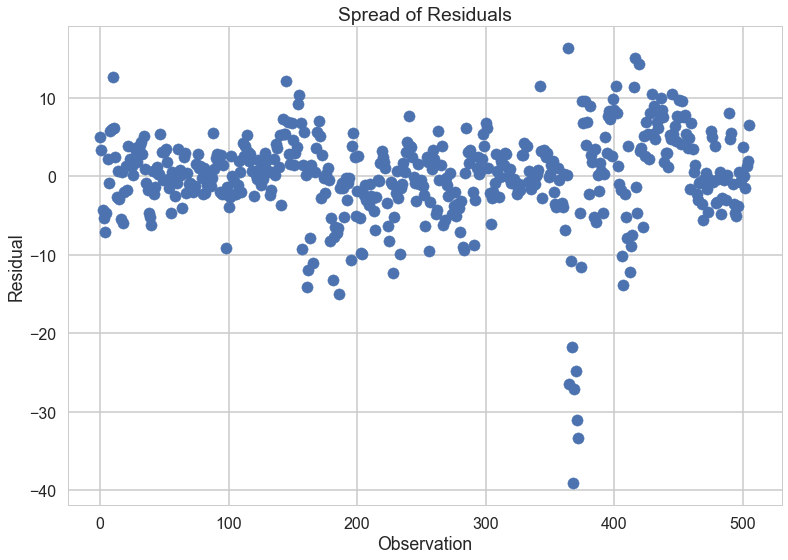

In [252]:
residuals = (y_no_intercept_predict - y)
X = np.arange(0,len(residuals))
plt.scatter(X,residuals)
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.title('Spread of Residuals')
plt.show()

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{full} - RSS_{reduced}}{K_{full} - K_{reduced}} \right)}{\left( \frac{RSS_{reduced}}{N - K_{reduced}} \right)}$$

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [475]:
r_coef = dict()
for column in bos.columns:
    r = scipy.stats.pearsonr(bos[column],bos.PRICE)[0]
    log_r = scipy.stats.pearsonr(np.log(bos[column]),bos.PRICE)[0]
    if not r_coef:
        r_coef['Pearson Correlation'] = [r]
        r_coef['Variable'] = [column]
        r_coef['Pearson Correlation (log)'] = [log_r]
    else:
        r_coef['Pearson Correlation'].append(r)
        r_coef['Variable'].append(column)
        r_coef['Pearson Correlation (log)'].append(log_r)
        
correlated = pd.DataFrame(r_coef).set_index('Variable').sort_values('Pearson Correlation')
correlated

C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:3018: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my
C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,Pearson Correlation,Pearson Correlation (log)
Variable,,
LSTAT,-0.737663,-0.815442
PTRATIO,-0.507787,-0.503160
INDUS,-0.483725,-0.519270
TAX,-0.468536,-0.474701
NOX,-0.427321,-0.430806
CRIM,-0.385832,-0.452284
RAD,-0.381626,-0.342632
AGE,-0.376955,-0.326512
CHAS,0.175260,NaN


Based on the pearson correlation coeffecient, we can see that the log of LSTAT and the log of INDUS has higher absolute correlation with price. This means that they might be a good explanatory variable in the distribution of prices. Let's use these two variables in our model

In [482]:
df = bos.loc[:,['CRIM','RM','PTRATIO','LSTAT','INDUS','PRICE']]
df['LSTAT'] = np.log(df.LSTAT)
df['INDUS'] = np.log(df.INDUS)

model = ols('PRICE ~ CRIM + RM + PTRATIO + LSTAT + INDUS -1',df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2223.
Date:                Mon, 02 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:06:56   Log-Likelihood:                -1537.8
No. Observations:                 506   AIC:                             3086.
Df Residuals:                     501   BIC:                             3107.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.1215      0.029     -4.210      0.0

## Analysis
-----------------------------
When adding the two new variables of the log(INDUS) and log(LSTAT) we can see an improved $R^2$ score of 0.957 in comparison to the first model's $R^2$ score of 0.942. This in comparison with the AIC: 3086 of the new model and AIC: 3232 of the old model, a lower AIC represents an improvement of one model over another




## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

In [355]:
# Your turn.
import statsmodels.formula.api as sm
from scipy.stats import probplot, shapiro
from statsmodels.graphics.regressionplots import *
from statsmodels.graphics.regressionplots import *


In [559]:
#construct a function that will analyze a given model
def try_model(df,y,cache):
        #extrapolate the disred model variables
        formula = ' + '.join(list(df.columns))
        df['PRICE'] = y
        #fit the model
        m = ols('PRICE ~ {}'.format(formula), df).fit()
        
        #if the intercept coeffecient is statistically insignificant, then fit the model with beta naught (intercept coef)
        if m.pvalues['Intercept'] > 0.05:
            m = ols('PRICE ~ {}'.format(formula) + '-1', df).fit()
        
        print(m.summary())
        
        #calculate the residuals
        residuals =  m.fittedvalues - y

        #residuals plot
        fig = plt.figure()
        plt.scatter(np.arange(len(residuals)),residuals, c='r', alpha = 0.5)
        plt.plot(np.arange(len(residuals)), [0]*len(residuals), marker = '.', color = 'k')
        plt.xlabel('Observations')
        plt.ylabel('Residuals')
        plt.margins(0.02)
        plt.show()
        
        #probability plot
        probplot(residuals, plot=plt)
        plt.show()
        
        #distribution of residuals
        plt.hist(residuals, bins = 40)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Residuals')
        plt.show()
        
        #incluence plots
        influence = m.get_influence()
        #c is the distance and p is p-value
        (c, p) = influence.cooks_distance
        plt.stem(np.arange(len(c)), c, markerfmt=",")
        plt.show()
        
        #influcence plot
        influence_plot(m)
        plt.show()
        
        #leverage plot
        plot_leverage_resid2(m)
        plt.show()
        
        #return the statistics of interest
        if not cache:
            cache = {'rsquared':[(m.rsquared)],
                     'rsquared adjusted':[(m.rsquared_adj)],
                     'AIC':[(m.aic)],
                     'Variables':[(list(df.columns))],
                     'Coef':[(list(m.params))],
                     'F-prob':[(m.f_pvalue)],
                     'Residuals':[(residuals)]}
            return cache
                          
        else:
            cache['rsquared'].append((m.rsquared))
            cache['rsquared adjusted'].append((m.rsquared_adj))
            cache['AIC'].append((m.aic))
            cache['Variables'].append((list(df.columns)))
            cache['Coef'].append((list(m.params)))
            cache['F-prob'].append((m.f_pvalue))
            cache['Residuals'].append((residuals))
        return cache

# MODEL #1

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     2721.
Date:                Mon, 02 Apr 2018   Prob (F-statistic):          2.10e-310
Time:                        02:17:30   Log-Likelihood:                -1612.9
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     503   BIC:                             3244.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             7.1118      0.230     30.871      0.0

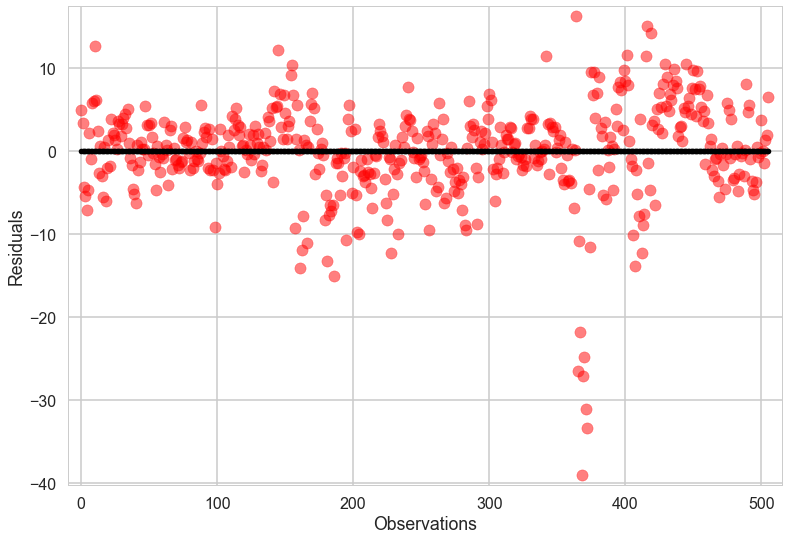

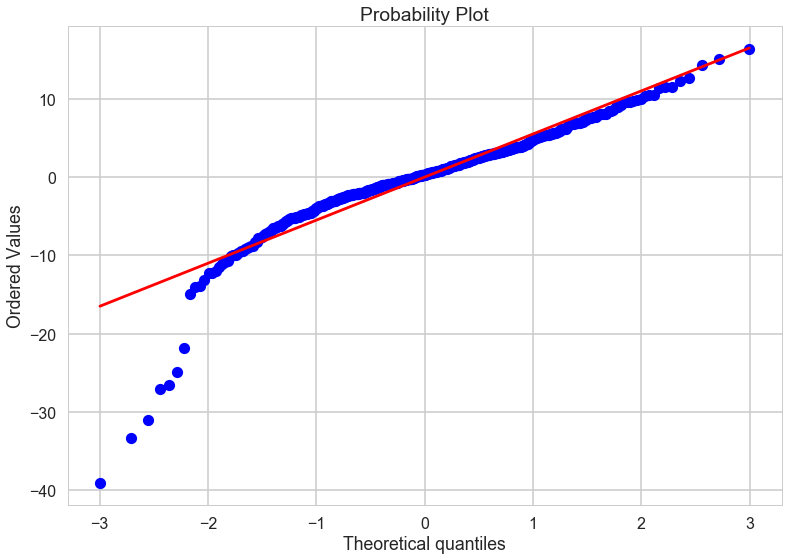

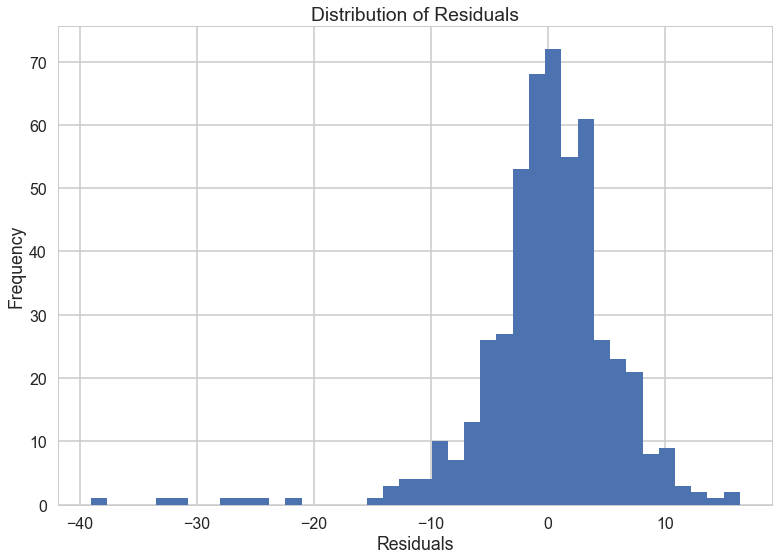

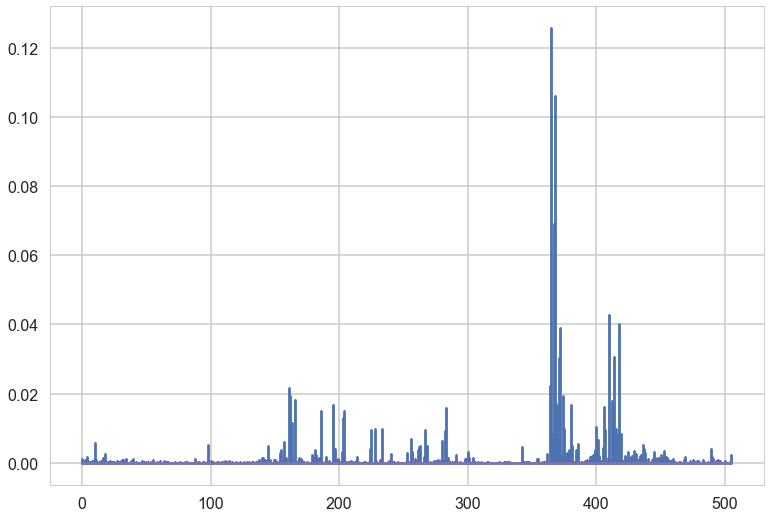

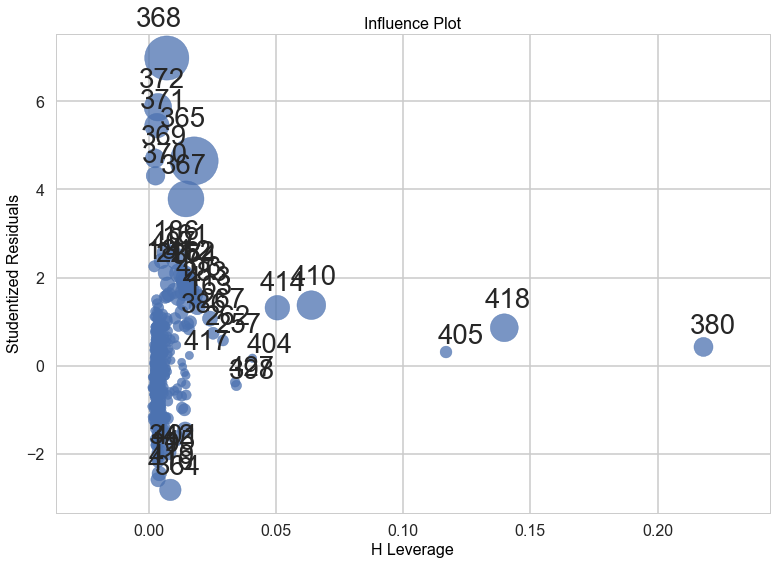

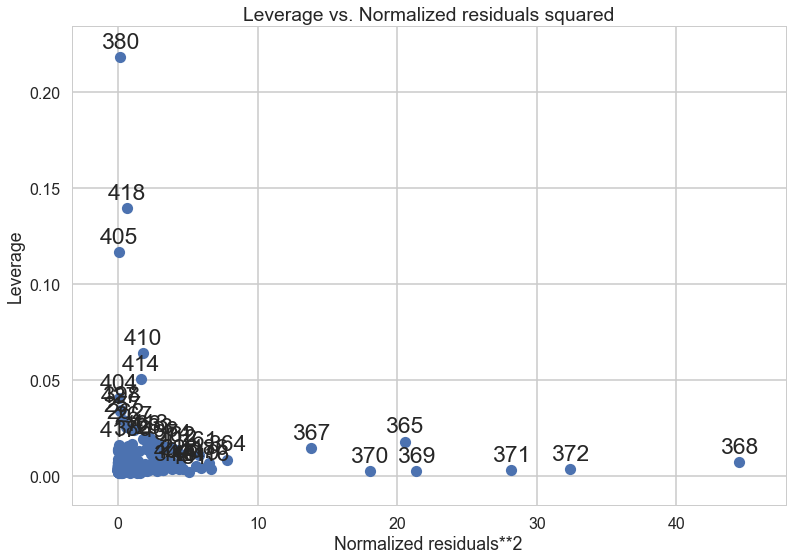

In [560]:
cache = try_model(bos.loc[:,['RM','CRIM','PTRATIO']],bos.PRICE, cache = dict())

# MODEL #2 (OUTLIERS REMOVED)

In [561]:
df2 = bos.loc[:,['RM','CRIM','PTRATIO','PRICE']]
df2['Residuals'] = np.squeeze(cache['Residuals'])
outliers = df2[df2.Residuals < -20].PRICE
outliers

365    27.5
367    23.1
368    50.0
369    50.0
370    50.0
371    50.0
372    50.0
Name: PRICE, dtype: float64

#### Outliers Analysis
----------
Of the 7 identified outliers, 5 of them have the same price of \$500,000. This seems like it could be an anomaly in the data taking process, or maybe a very small sample in a very high price fancy neighborhood. Either way they don't seem to be very representative of the entire population, and can be removed

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     4110.
Date:                Mon, 02 Apr 2018   Prob (F-statistic):               0.00
Time:                        02:11:11   Log-Likelihood:                -1481.0
No. Observations:                 499   AIC:                             2968.
Df Residuals:                     496   BIC:                             2981.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             7.4917      0.188     39.861      0.0

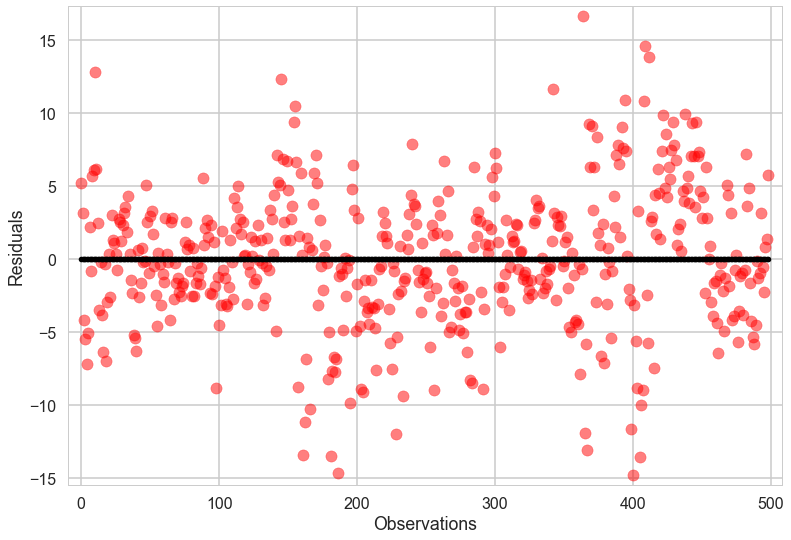

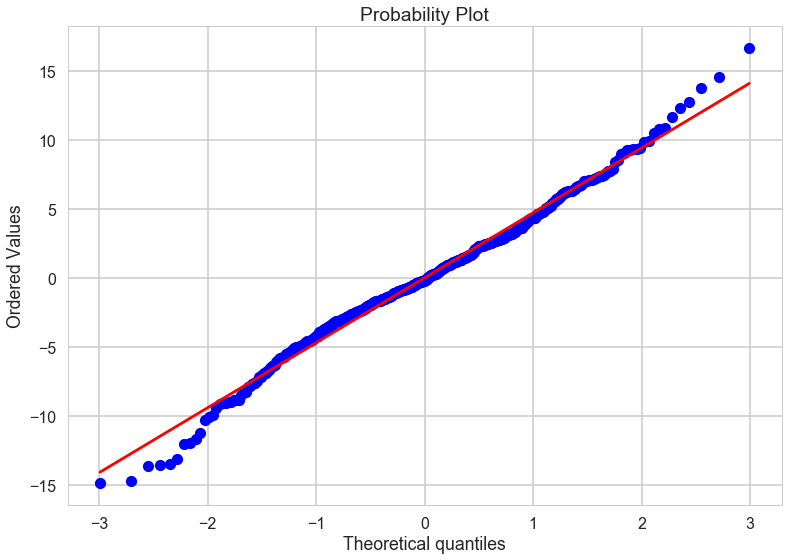

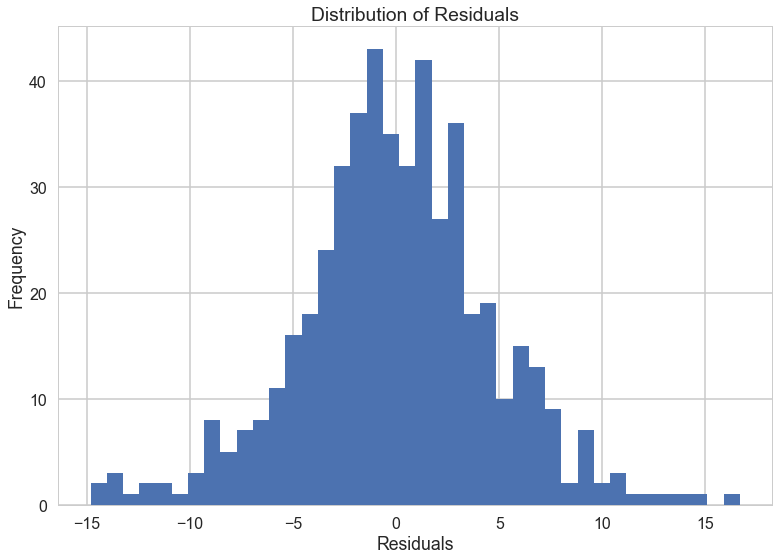

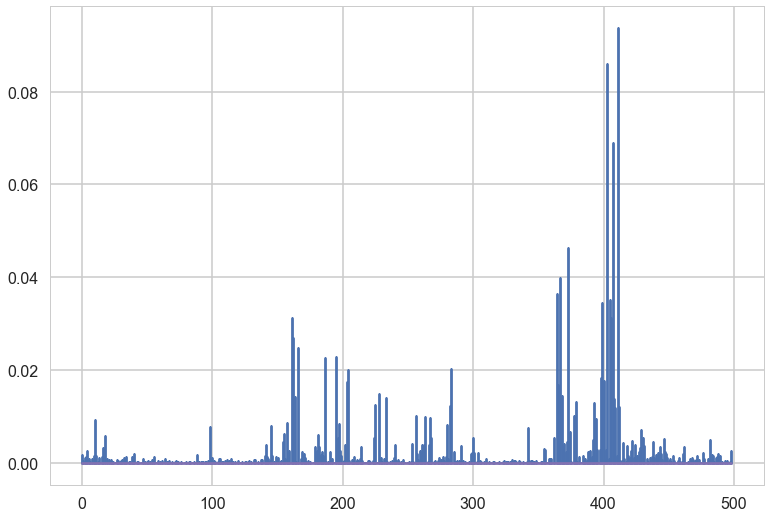

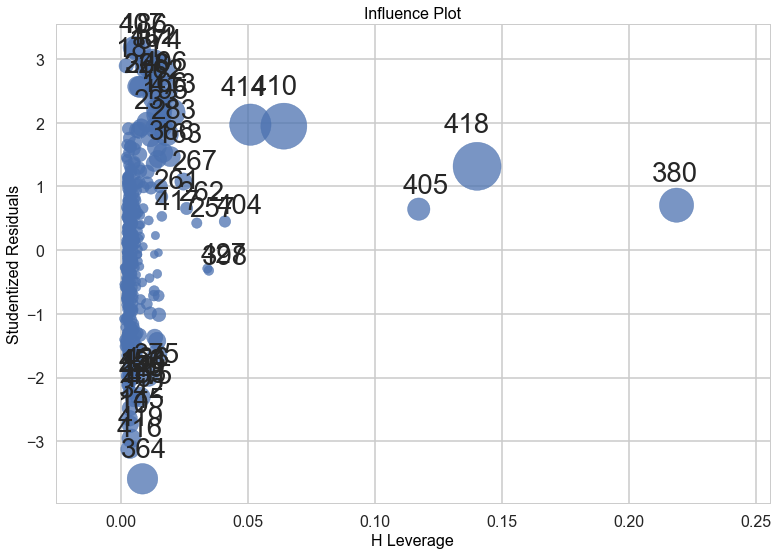

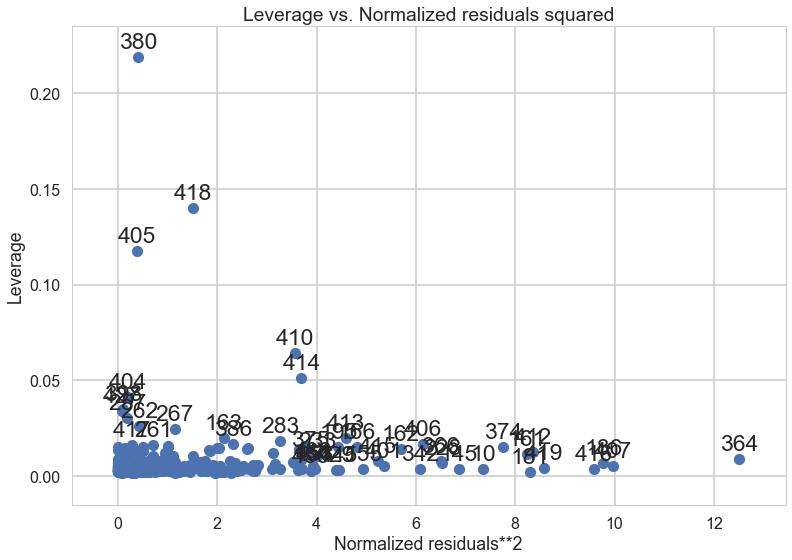

In [557]:
df2 = df2[df2.Residuals > -20]
y = df2.PRICE
cache = try_model(df2.drop(['PRICE','Residuals'],axis=1),y,cache)

# Analysis

### Residuals vs. Fitted Plot
----------------------
When looking at the distribution of the residuals plot, the first thing to note is that the distribution is centered around 0 since the sum of the residuals should equal to 0. The next trend to investigate in the residuals plot is the spread of variance in the X-direction. The spread of variance should be just about equal and symmetric for the whole distribution about the 0 point. This seems to be the trend **except** for around observations 370 to 380. There are several residuals well below -20, violating the symmetric spread of variance rules. These data points might be outliers.

### Quantile Plot
--------------------------
The other requirement of residuals apart from their sum being equal to 0 and their variance being equal and symmetric about the 0 point, is that their distribution must be normal. A test to determine normality is plotting the residuals on a Quantile plot (probability plot). If the residuals were to be normal, their plot on the quantile plot would be a straight on the projected line. However in the quantile plot above, there is slight departure from the line at the bottom of the graph. Apart from that, the line is almost on top of the projected line. This pattern is one that appears to be left skewed. When plotting the histogram of residuals, it is indeed left skewed. Again this skewness is attributed to what appeared to be those outliers on the initial residuals plot that were below -20

### Leverage Plot
----------------------------
We first identified the outliers per the residuals plot, and they were located at observation numbers 365, 367, 368, 369, 370, 371, and 372. When examining the leverage plots, these are the exact obersvations dominating the leverage plots. All other observations appear clustered amongst each other in the leverage plot, and this is due to the spread out nature of the assumed outliers within the leverage plot. The proper way to interpret this is that by excluding these values, it would affect the slope coeffecient, which in turn would affect $R^2$. When comparing the $R^2$ values from model 1 with the outliers to model 2 without, we can see that $R^2$ has improved between the two models: 0.942 to 0.961 respectively.

### Results
Overall it can be seen both qualitatively (graphs) and quantitatively (statistical values) that removing the perceived outliers improved the model. The spread of the residuals appears to be symmetric about the 0 point and almost linear in the Quantile plot which tests for normality. Also, 96% of the spread in variance can be explained by the modle. This is a 2% improvement over the first model